# TP regression logistique
## les données: MNIST

In [3]:
#imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.utils import shuffle

In [14]:
# reading the dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# you can change the classes
class1 = 1
class2 = 3
nameClass1 = '1'
nameClass2 = '3'

## TRAIN
#class 1: positives
x_train1 = x_train[y_train==class1,:]
#class 2: negatives
x_train2 = x_train[y_train==class2,:]
# merging the 2 classes and shuffle
x_trainBinaire = np.append(x_train1,x_train2,axis=0)
y_trainBinaire = np.append(np.full(len(x_train1),-1), np.full(len(x_train2),1))
(x_trainBinaire,y_trainBinaire) = shuffle(x_trainBinaire,y_trainBinaire,random_state=0)

## TEST
#class 1: positives
x_test1 = x_test[y_test==class1,:]
#class 2: negatives
x_test2 = x_test[y_test==class2,:]
# merging the 2 classes and shuffle
x_testBinaire = np.append(x_test1,x_test2,axis=0)
y_testBinaire = np.append(np.full(len(x_test1),-1), np.full(len(x_test2),1))
(x_testBinaire,y_testBinaire) = shuffle(x_testBinaire,y_testBinaire,random_state=0)

# Retour sur le boosting, soit directement sur les données, soit avec filtres de Haar

## boosting binaire le + simple, directement sur les données
Pour cela, on va tout de même linéariser les images:

In [15]:
#train
print(x_trainBinaire.shape)
n = x_trainBinaire.shape[0]
x_trainBinaireLin = x_trainBinaire.reshape(n,-1)
print(x_trainBinaireLin.shape)
#test
n = x_testBinaire.shape[0]
x_testBinaireLin = x_testBinaire.reshape(n,-1)
print(x_trainBinaireLin.shape)


(12873, 28, 28)
(12873, 784)
(12873, 784)


(12873, 784)
(12873,)
learned


Text(0.5, 1.0, 'Matrice de confusion')

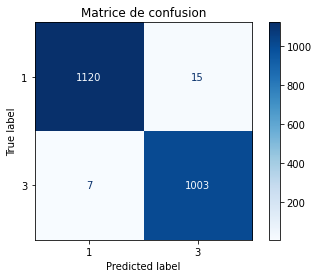

In [16]:
## apprentissage par boosting (Adaboost)
# création de l'object boosting
myboosting = ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1, algorithm='SAMME.R')
# apprentissage sur les données 'train'
print(x_trainBinaireLin.shape)
print(y_trainBinaire.shape)
myboosting.fit(x_trainBinaireLin,y_trainBinaire)
print("learned")

y_predBinaireTest = myboosting.predict(x_testBinaireLin)

disp = plot_confusion_matrix(myboosting, x_testBinaireLin, y_testBinaire,
                                 display_labels=[nameClass1,nameClass2],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matrice de confusion')

Que vaut le score F1?

In [73]:
print("F1 score : ", f1_score(y_predBinaireTest,y_testBinaire))

F1 score :  0.9891518737672582


F1 = 0.9892891918208374

## boosting binaire en utilisant les filtres de Haar
La première étape va préparer les données avant l'algorithme de boosting.

### filtres de Haar

Pour appliquer les filtres de Haar sur les images (2D), il faut re-exécuter toutes les cellules du début SAUF celle qui applatit les images en 1D.

In [74]:
# imports nécessaires
from skimage import feature
from skimage import transform

Pour les filtres de Haar, soit on les génère automatiquement par la librairie, soit on les construit soi-même.

In [75]:
# génération automatique à partir de 2 types:
#       'type-2-x' et 'type-2-y'
# et dimensions des images: 28x28
# 1 filtre sur 200 pour réduire le nombre de filtres
feat_coord, feat_type = feature.haar_like_feature_coord(28,28, ['type-2-x','type-2-y'])
feat_coord = feat_coord[::2000]
feat_type = feat_type[::2000]
print(feat_coord.shape)


(80,)


In [76]:
from tqdm import tqdm
# transformation des images: on applique tous les filtres
cpt=0

for image in tqdm(x_trainBinaire):
    # calcul de l'image intégrale
    int_image = transform.integral_image(image)
    # calcul des filtre de Haar
    features = feature.haar_like_feature(int_image, 0, 0, 28, 28,feature_type=feat_type,feature_coord=feat_coord)
    if cpt == 0:
        ftrainBinaire1 = [features]
    else:
        ftrainBinaire1 = np.append(ftrainBinaire1,[features],axis=0)
    cpt += 1
    
cpt = 0    
for image in tqdm(x_testBinaire):
    # calcul de l'image intégrale
    int_image = transform.integral_image(image)
    # calcul des filtre de Haar
    features = feature.haar_like_feature(int_image, 0, 0, 28, 28,feature_type=feat_type,feature_coord=feat_coord)
    if cpt == 0:
        ftestBinaire1 = [features]
    else:
        ftestBinaire1 = np.append(ftestBinaire1,[features],axis=0)
    cpt += 1
    
        

100%|██████████| 2145/2145 [00:00<00:00, 4784.77it/s]


In [77]:
## apprentissage par boosting (Adaboost)
# création de l'object boosting
myboostingHaar1 = ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1, algorithm='SAMME.R')
# apprentissage sur les données 'train'
myboostingHaar1.fit(ftrainBinaire1,y_trainBinaire)


AdaBoostClassifier(learning_rate=1)

(1920,)
(1920, 80)
(1920,)
F1 score :  0.9951267056530215


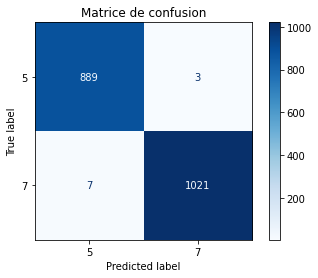

In [26]:
# calcul de la matrice de confusion et affichage

y_predBinaire = myboostingHaar1.predict(ftestBinaire1)
print(y_predBinaire.shape)
print(ftestBinaire1.shape)
print(y_testBinaire.shape)
disp = plot_confusion_matrix(myboostingHaar1, ftestBinaire1, y_testBinaire,
                                 display_labels=[nameClass1, nameClass2],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matrice de confusion')
print("F1 score : ", f1_score(y_predBinaire,y_testBinaire))

Quelle approche donne de meilleurs résultats ? Pourquoi ?

F1 = 0.9965969859017988 en prenant 1 filtre sur 200

F1 = 0.9951267056530215 en prenant 1 filtre sur 2000

Les résultats avec les filtres de haar ou sans sont quasiment identiques (légèrement avec les filtres). On voit aussi que le score est le même que l'on prenne 1 filtre sur 200 ou 1 filtre 2000.

Cependant le calcul des filtres prend du temps, il n'est très intéressant de l'utiliser ici.

F1 max = 1 donc il n'y a pas beaucoup de marge d'amélioration. De plus les images sont ici assez simples. Les filtres ont pour but de révéler des patterns plus complexes. Donc ici ce n'est pas nécessaire de les utiliser.


# Régression logistique

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression

## Régression logistique sur les données brutes

In [78]:
#default constructor
myRegLog = LogisticRegression()
#myRegLog = LogisticRegression(penalty="elasticnet",solver="saga",l1_ratio=0.5)
#learning
myRegLog.fit(x_trainBinaireLin,y_trainBinaire)
print("learning done")


learning done


/home/safwane/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Un message d'erreur a du s'afficher. Que signifie t-il ? Vous pouvez néanmoins afficher les performances sur la base de test:

F1 score :  0.9910625620655412


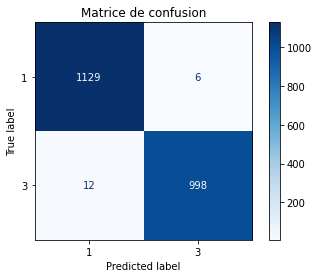

In [79]:
y_predBinaireTest = myRegLog.predict(x_testBinaireLin)

disp = plot_confusion_matrix(myRegLog, x_testBinaireLin, y_testBinaire,
                                 display_labels=[nameClass1,nameClass2],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matrice de confusion')
print("F1 score : ", f1_score(y_predBinaireTest,y_testBinaire))

Rien ne change le score

La régression logistique a été construite avec tous les paramètres par défaut. Suivez les recommandations du message d'erreur et testez les différents paramètres:
- terminaison de l'algorithme: nombre d'itérations maximal, ...
- prétraitement des données: normalisation
- solveur
- régularisation
Obtenez-vous de meilleurs résultats?

## Régression logistique sur les données après filtres de Haar

learning done
F1 score :  0.9945463559742191


/home/safwane/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


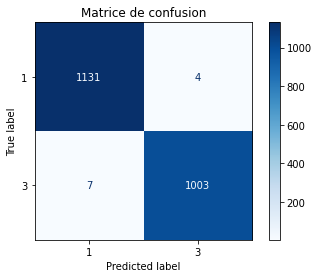

In [80]:
# à vous de jouer

myRegLog.fit(ftrainBinaire1,y_trainBinaire)
print("learning done")

y_predBinaireTest = myRegLog.predict(ftestBinaire1)

disp = plot_confusion_matrix(myRegLog, ftestBinaire1, y_testBinaire,
                                 display_labels=[nameClass1,nameClass2],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matrice de confusion')
print("F1 score : ", f1_score(y_predBinaireTest,y_testBinaire))

In [ ]:
# Comparez les différents résultats et concluez.